In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from dateutil import tz

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

from joblib import dump

In [2]:
# loading data

solar = pd.read_csv("../course/datasets/solar.csv")
weather = pd.read_csv("../course/datasets/weather.csv")
sun = pd.read_excel('../course/datasets/sunrise-sunset.xlsx')

# Solar prep

In [3]:
# standardizing the timestamp

solar['timestamp'] = pd.to_datetime(solar['timestamp'], utc=True).dt.floor('h')

solar

,timestamp,kwh
0,2023-03-11 15:00:00+00:00,0.5400
1,2023-03-11 16:00:00+00:00,1.0200
2,2023-03-11 17:00:00+00:00,1.1700
3,2023-03-11 18:00:00+00:00,1.1800
4,2023-03-11 19:00:00+00:00,1.1800
...,...,...
9700,2024-04-19 04:00:00+00:00,2417.3321
9701,2024-04-19 05:00:00+00:00,2417.3321
9702,2024-04-19 06:00:00+00:00,2417.3336
9703,2024-04-19 07:00:00+00:00,2417.3701


<Axes: xlabel='timestamp', ylabel='kwh'>

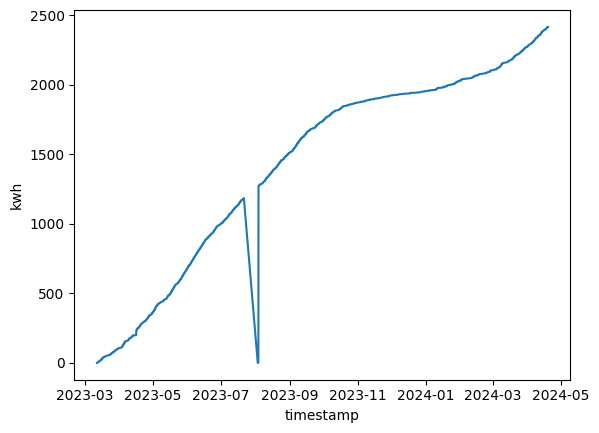

In [4]:
sns.lineplot(x='timestamp', y='kwh', data=solar)

In [5]:
# checking for missing values

nans = solar.isna().any()
nans

timestamp    False
kwh          False
dtype: bool

In [6]:
solar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9705 entries, 0 to 9704
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   timestamp  9705 non-null   datetime64[ns, UTC]
 1   kwh        9705 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(1)
memory usage: 151.8 KB


In [7]:
solar.drop(solar.loc[solar["kwh"] == 0].index, inplace=True)

In [8]:
# transforming kwh to hourly values

solar["kwh"] = solar["kwh"].diff().fillna(0)

In [9]:
solar.describe()

,kwh
count,9400.000000
mean,0.257121
std,17.926695
min,-1185.138200
25%,0.000000
50%,0.000000
75%,0.249300
max,1269.965600


<Axes: >

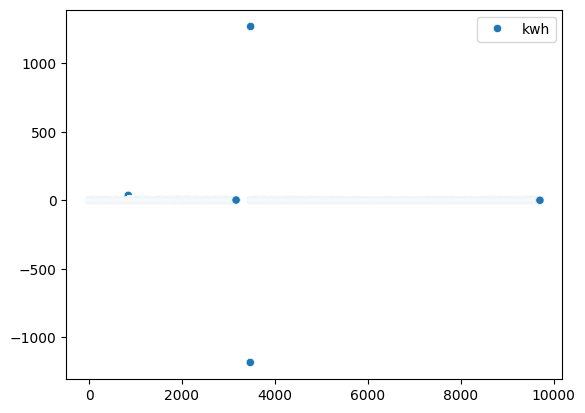

In [10]:
# visualizing solar

sns.scatterplot(solar)

In [11]:
# removing outliers

outliers = solar[(solar['kwh'] > 3) | (solar['kwh'] < 0)]

outliers

,timestamp,kwh
845,2023-04-15 20:00:00+00:00,36.1945
3471,2023-08-03 06:00:00+00:00,-1185.1382
3478,2023-08-03 13:00:00+00:00,1269.9656


In [12]:
solar = solar.drop(outliers.index)

<Axes: >

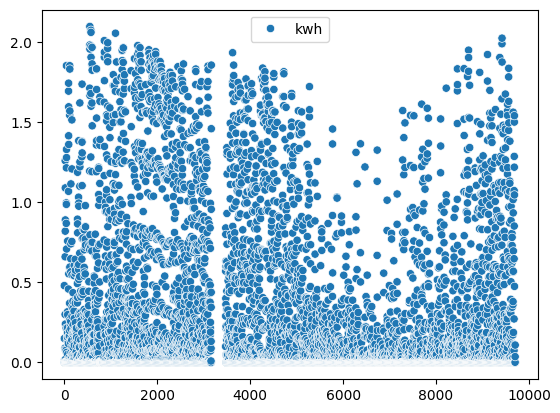

In [13]:
sns.scatterplot(solar)

# Weather prep

In [14]:
# standardizing the timestamp

weather["timestamp"] = pd.to_datetime(weather["timestamp"], utc=True)

# removing unnecessary columns

weather = weather[["timestamp", "temp", "humidity_relative", "pressure", "cloudiness"]]

weather

,timestamp,temp,humidity_relative,pressure,cloudiness
0,2023-03-01 09:00:00+00:00,4.9,54.3,1029.7,0.0
1,2023-03-01 09:00:00+00:00,2.1,73.7,1029.3,NaN
2,2023-03-01 09:00:00+00:00,3.3,NaN,1029.6,1.0
3,2023-03-01 09:00:00+00:00,1.6,70.9,1029.4,NaN
4,2023-03-01 10:00:00+00:00,3.0,60.8,1028.8,NaN
...,...,...,...,...,...
39835,2024-04-19 07:00:00+00:00,10.6,NaN,1013.5,8.0
39836,2024-04-19 08:00:00+00:00,10.0,90.5,1012.7,NaN
39837,2024-04-19 08:00:00+00:00,10.8,NaN,1013.2,8.0
39838,2024-04-19 08:00:00+00:00,9.9,89.7,1013.6,NaN


In [15]:
# identifying missing values

nans = weather.isna().any()
nans

timestamp            False
temp                 False
humidity_relative     True
pressure              True
cloudiness            True
dtype: bool

In [16]:
# showing the percentage of missing values

nans_percentage = weather.isnull().mean() * 100
nans_percentage

timestamp             0.000000
temp                  0.000000
humidity_relative    25.000000
pressure              0.030120
cloudiness           61.207329
dtype: float64

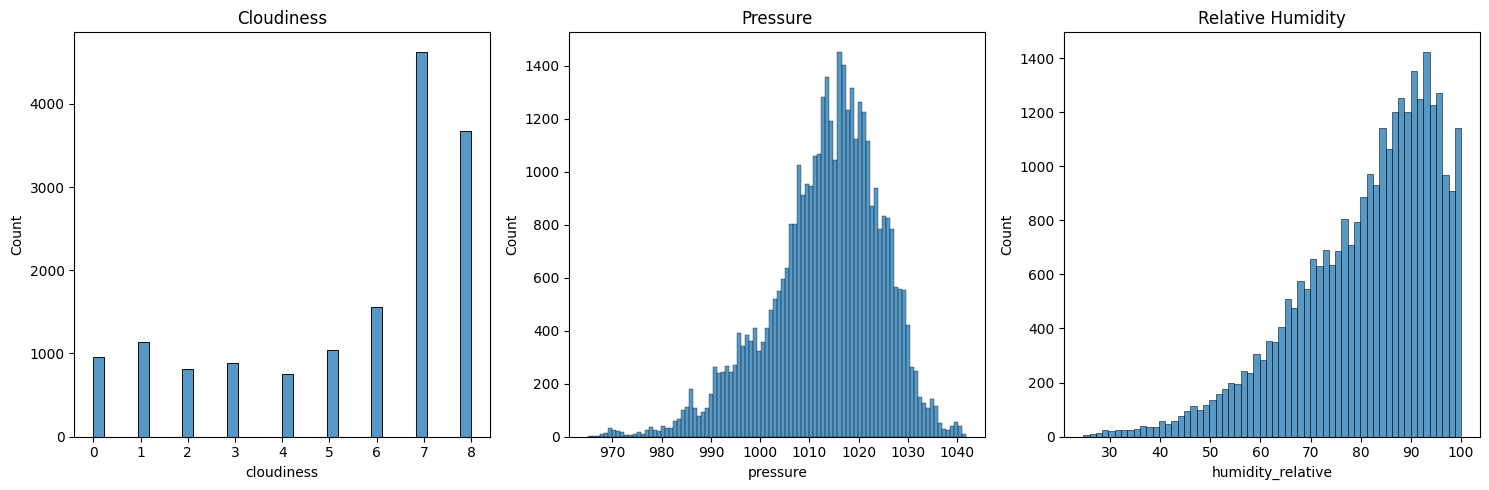

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(weather['cloudiness'], ax=axs[0])
axs[0].set_title('Cloudiness')

sns.histplot(weather['pressure'], ax=axs[1])
axs[1].set_title('Pressure')

sns.histplot(weather['humidity_relative'], ax=axs[2])
axs[2].set_title('Relative Humidity')

plt.tight_layout()
plt.show()

In [18]:
# filling missing values

weather = pd.DataFrame(weather.groupby("timestamp")[["temp", "pressure", "cloudiness", "humidity_relative"]].mean())

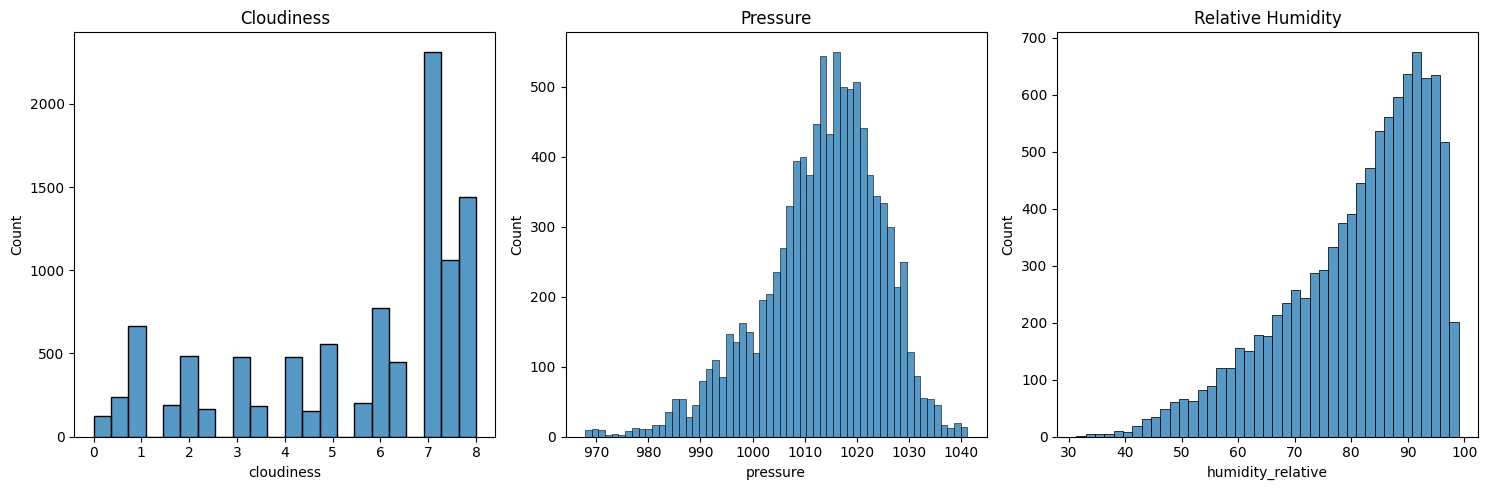

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(weather['cloudiness'], ax=axs[0])
axs[0].set_title('Cloudiness')

sns.histplot(weather['pressure'], ax=axs[1])
axs[1].set_title('Pressure')

sns.histplot(weather['humidity_relative'], ax=axs[2])
axs[2].set_title('Relative Humidity')

plt.tight_layout()
plt.show()

In [20]:
# checking again

nans = weather.isna().any()
nans

temp                 False
pressure             False
cloudiness           False
humidity_relative    False
dtype: bool

# Sunrise prep

In [21]:
sun

,datum,Opkomst,Op ware middag,Ondergang
0,2023-01-01,08:45:00,12:46:00,16:47:00
1,2023-01-02,08:45:00,12:46:00,16:48:00
2,2023-01-03,08:45:00,12:47:00,16:49:00
3,2023-01-04,08:44:00,12:47:00,16:51:00
4,2023-01-05,08:44:00,12:48:00,16:52:00
...,...,...,...,...
726,2024-12-27,08:45:00,12:44:00,16:43:00
727,2024-12-28,08:45:00,12:44:00,16:44:00
728,2024-12-29,08:45:00,12:45:00,16:45:00
729,2024-12-30,08:45:00,12:45:00,16:46:00


In [22]:
brussels = tz.gettz('Europe/Brussels')

def convert_to_dt(dt):
    temp = datetime.strptime(dt, '%Y-%m-%d %H:%M:%S')
    temp = temp.replace(tzinfo=brussels)
    return temp.astimezone(tz.UTC)

In [23]:
sun = sun.astype("str")

sun = sun.rename(columns={"datum": "date"})

sun["timestamp_sunrise"] = (sun["date"] + " " + sun["Opkomst"]).apply(convert_to_dt).dt.tz_convert("UTC").dt.floor("h")
sun["timestamp_noon"] = (sun["date"] + " " + sun["Op ware middag"]).apply(convert_to_dt).dt.tz_convert("UTC")
sun["timestamp_sundown"] = (sun["date"] + " " + sun["Ondergang"]).apply(convert_to_dt).dt.tz_convert("UTC").dt.ceil("h")

sun.drop(columns=["Opkomst", "Op ware middag", "Ondergang"], inplace=True)

sun

,date,timestamp_sunrise,timestamp_noon,timestamp_sundown
0,2023-01-01,2023-01-01 07:00:00+00:00,2023-01-01 11:46:00+00:00,2023-01-01 16:00:00+00:00
1,2023-01-02,2023-01-02 07:00:00+00:00,2023-01-02 11:46:00+00:00,2023-01-02 16:00:00+00:00
2,2023-01-03,2023-01-03 07:00:00+00:00,2023-01-03 11:47:00+00:00,2023-01-03 16:00:00+00:00
3,2023-01-04,2023-01-04 07:00:00+00:00,2023-01-04 11:47:00+00:00,2023-01-04 16:00:00+00:00
4,2023-01-05,2023-01-05 07:00:00+00:00,2023-01-05 11:48:00+00:00,2023-01-05 16:00:00+00:00
...,...,...,...,...
726,2024-12-27,2024-12-27 07:00:00+00:00,2024-12-27 11:44:00+00:00,2024-12-27 16:00:00+00:00
727,2024-12-28,2024-12-28 07:00:00+00:00,2024-12-28 11:44:00+00:00,2024-12-28 16:00:00+00:00
728,2024-12-29,2024-12-29 07:00:00+00:00,2024-12-29 11:45:00+00:00,2024-12-29 16:00:00+00:00
729,2024-12-30,2024-12-30 07:00:00+00:00,2024-12-30 11:45:00+00:00,2024-12-30 16:00:00+00:00


In [24]:
sun.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   date               731 non-null    object             
 1   timestamp_sunrise  731 non-null    datetime64[ns, UTC]
 2   timestamp_noon     731 non-null    datetime64[ns, UTC]
 3   timestamp_sundown  731 non-null    datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](3), object(1)
memory usage: 23.0+ KB


In [25]:
sun["date"] = pd.to_datetime(sun["date"])

In [26]:
sun.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   date               731 non-null    datetime64[ns]     
 1   timestamp_sunrise  731 non-null    datetime64[ns, UTC]
 2   timestamp_noon     731 non-null    datetime64[ns, UTC]
 3   timestamp_sundown  731 non-null    datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](3), datetime64[ns](1)
memory usage: 23.0 KB


In [27]:
sun.to_csv('sun.csv', index=False)

# Merging

In [28]:
df = pd.merge(solar, weather, on='timestamp')

In [29]:
df["date"] = pd.to_datetime((df["timestamp"]).dt.date)

In [30]:
df = pd.merge(df, sun, on="date", how="left")

In [31]:
df

,timestamp,kwh,temp,pressure,cloudiness,humidity_relative,date,timestamp_sunrise,timestamp_noon,timestamp_sundown
0,2023-03-11 15:00:00+00:00,0.0000,6.850,1012.025,6.0,54.833333,2023-03-11,2023-03-11 06:00:00+00:00,2023-03-11 11:53:00+00:00,2023-03-11 18:00:00+00:00
1,2023-03-11 16:00:00+00:00,0.4800,6.300,1011.625,7.0,57.800000,2023-03-11,2023-03-11 06:00:00+00:00,2023-03-11 11:53:00+00:00,2023-03-11 18:00:00+00:00
2,2023-03-11 17:00:00+00:00,0.1500,5.950,1011.500,7.0,60.366667,2023-03-11,2023-03-11 06:00:00+00:00,2023-03-11 11:53:00+00:00,2023-03-11 18:00:00+00:00
3,2023-03-11 18:00:00+00:00,0.0100,5.250,1011.850,7.0,64.500000,2023-03-11,2023-03-11 06:00:00+00:00,2023-03-11 11:53:00+00:00,2023-03-11 18:00:00+00:00
4,2023-03-11 19:00:00+00:00,0.0000,4.850,1011.650,7.0,68.633333,2023-03-11,2023-03-11 06:00:00+00:00,2023-03-11 11:53:00+00:00,2023-03-11 18:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...
9392,2024-04-19 04:00:00+00:00,0.0000,8.750,1014.100,7.5,93.900000,2024-04-19,2024-04-19 04:00:00+00:00,2024-04-19 11:42:00+00:00,2024-04-19 19:00:00+00:00
9393,2024-04-19 05:00:00+00:00,0.0000,9.300,1013.675,7.5,93.600000,2024-04-19,2024-04-19 04:00:00+00:00,2024-04-19 11:42:00+00:00,2024-04-19 19:00:00+00:00
9394,2024-04-19 06:00:00+00:00,0.0015,9.575,1013.475,8.0,91.666667,2024-04-19,2024-04-19 04:00:00+00:00,2024-04-19 11:42:00+00:00,2024-04-19 19:00:00+00:00
9395,2024-04-19 07:00:00+00:00,0.0365,9.925,1013.325,8.0,91.066667,2024-04-19,2024-04-19 04:00:00+00:00,2024-04-19 11:42:00+00:00,2024-04-19 19:00:00+00:00


In [32]:
df["daytime"] = np.where((df["timestamp"] >= df["timestamp_sunrise"]) & (df["timestamp"] <= df["timestamp_sundown"]), 1, 0)
df["time_from_noon"] = np.where(df["timestamp"] < df["timestamp_noon"], 
                           (df["timestamp_noon"] - df["timestamp"]).dt.total_seconds() / 60,
                           (df["timestamp"] - df["timestamp_noon"]).dt.total_seconds() / 60)
df["sunlight_time"] = (df["timestamp_sundown"] - df["timestamp_sunrise"]).dt.total_seconds() / 60

def get_season(month):
    if month in [12, 1, 2]: # winter
        return '0'
    elif month in [3, 4, 5]: # spring
        return '1'
    elif month in [6, 7, 8]: # summer
        return '2'
    else: # autumn
        return '3'

df['season'] = df['timestamp'].dt.month.apply(get_season)
df['month'] = df['timestamp'].dt.month
df["hour"] = df["timestamp"].dt.hour

df

,timestamp,kwh,temp,pressure,cloudiness,humidity_relative,date,timestamp_sunrise,timestamp_noon,timestamp_sundown,daytime,time_from_noon,sunlight_time,season,month,hour
0,2023-03-11 15:00:00+00:00,0.0000,6.850,1012.025,6.0,54.833333,2023-03-11,2023-03-11 06:00:00+00:00,2023-03-11 11:53:00+00:00,2023-03-11 18:00:00+00:00,1,187.0,720.0,1,3,15
1,2023-03-11 16:00:00+00:00,0.4800,6.300,1011.625,7.0,57.800000,2023-03-11,2023-03-11 06:00:00+00:00,2023-03-11 11:53:00+00:00,2023-03-11 18:00:00+00:00,1,247.0,720.0,1,3,16
2,2023-03-11 17:00:00+00:00,0.1500,5.950,1011.500,7.0,60.366667,2023-03-11,2023-03-11 06:00:00+00:00,2023-03-11 11:53:00+00:00,2023-03-11 18:00:00+00:00,1,307.0,720.0,1,3,17
3,2023-03-11 18:00:00+00:00,0.0100,5.250,1011.850,7.0,64.500000,2023-03-11,2023-03-11 06:00:00+00:00,2023-03-11 11:53:00+00:00,2023-03-11 18:00:00+00:00,1,367.0,720.0,1,3,18
4,2023-03-11 19:00:00+00:00,0.0000,4.850,1011.650,7.0,68.633333,2023-03-11,2023-03-11 06:00:00+00:00,2023-03-11 11:53:00+00:00,2023-03-11 18:00:00+00:00,0,427.0,720.0,1,3,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9392,2024-04-19 04:00:00+00:00,0.0000,8.750,1014.100,7.5,93.900000,2024-04-19,2024-04-19 04:00:00+00:00,2024-04-19 11:42:00+00:00,2024-04-19 19:00:00+00:00,1,462.0,900.0,1,4,4
9393,2024-04-19 05:00:00+00:00,0.0000,9.300,1013.675,7.5,93.600000,2024-04-19,2024-04-19 04:00:00+00:00,2024-04-19 11:42:00+00:00,2024-04-19 19:00:00+00:00,1,402.0,900.0,1,4,5
9394,2024-04-19 06:00:00+00:00,0.0015,9.575,1013.475,8.0,91.666667,2024-04-19,2024-04-19 04:00:00+00:00,2024-04-19 11:42:00+00:00,2024-04-19 19:00:00+00:00,1,342.0,900.0,1,4,6
9395,2024-04-19 07:00:00+00:00,0.0365,9.925,1013.325,8.0,91.066667,2024-04-19,2024-04-19 04:00:00+00:00,2024-04-19 11:42:00+00:00,2024-04-19 19:00:00+00:00,1,282.0,900.0,1,4,7


In [33]:
df = df[["kwh", "temp", "humidity_relative", "pressure", "cloudiness", "season", "month", "daytime", "sunlight_time", "time_from_noon", "hour"]]

In [34]:
df

,kwh,temp,humidity_relative,pressure,cloudiness,season,month,daytime,sunlight_time,time_from_noon,hour
0,0.0000,6.850,54.833333,1012.025,6.0,1,3,1,720.0,187.0,15
1,0.4800,6.300,57.800000,1011.625,7.0,1,3,1,720.0,247.0,16
2,0.1500,5.950,60.366667,1011.500,7.0,1,3,1,720.0,307.0,17
3,0.0100,5.250,64.500000,1011.850,7.0,1,3,1,720.0,367.0,18
4,0.0000,4.850,68.633333,1011.650,7.0,1,3,0,720.0,427.0,19
...,...,...,...,...,...,...,...,...,...,...,...
9392,0.0000,8.750,93.900000,1014.100,7.5,1,4,1,900.0,462.0,4
9393,0.0000,9.300,93.600000,1013.675,7.5,1,4,1,900.0,402.0,5
9394,0.0015,9.575,91.666667,1013.475,8.0,1,4,1,900.0,342.0,6
9395,0.0365,9.925,91.066667,1013.325,8.0,1,4,1,900.0,282.0,7


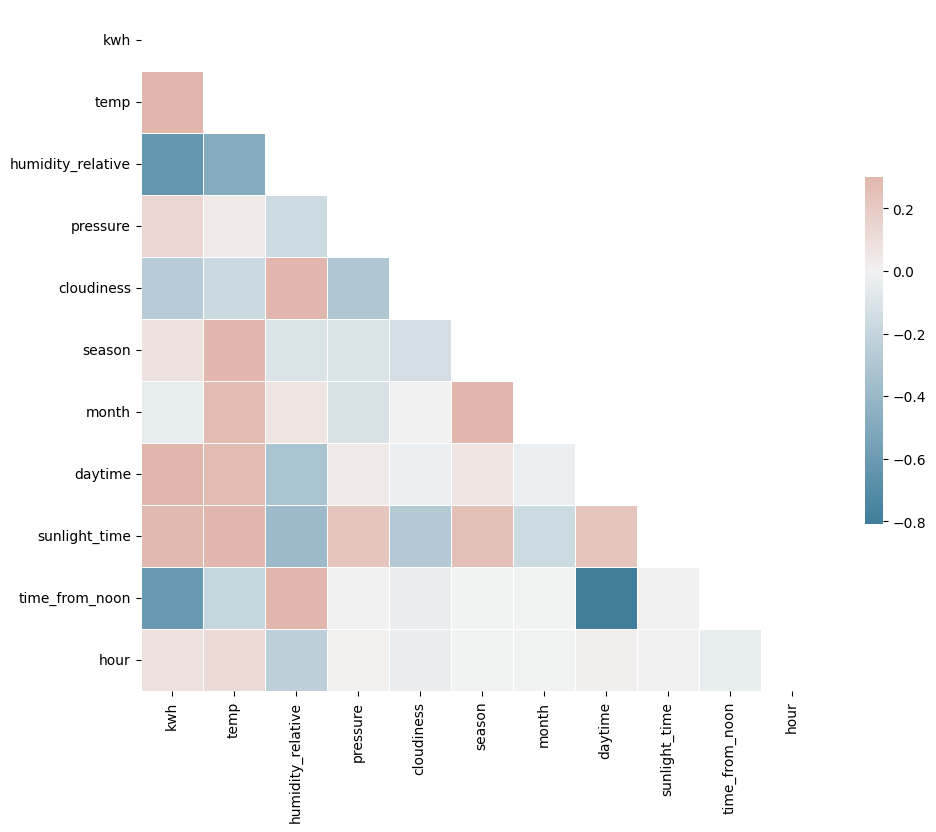

In [35]:
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [36]:
corr

,kwh,temp,humidity_relative,pressure,cloudiness,season,month,daytime,sunlight_time,time_from_noon,hour
kwh,1.000000,0.411971,-0.634142,0.148456,-0.266235,0.084336,-0.045864,0.456503,0.290394,-0.608343,0.089412
temp,0.411971,1.000000,-0.483195,0.042227,-0.174647,0.518969,0.269982,0.281302,0.595981,-0.190799,0.119825
humidity_relative,-0.634142,-0.483195,1.000000,-0.169587,0.367565,-0.102833,0.065440,-0.324964,-0.386334,0.320627,-0.236795
pressure,0.148456,0.042227,-0.169587,1.000000,-0.298073,-0.103835,-0.113029,0.042614,0.224337,0.000075,0.006717
cloudiness,-0.266235,-0.174647,0.367565,-0.298073,1.000000,-0.138858,0.002046,-0.021756,-0.281062,-0.034924,-0.034478
season,0.084336,0.518969,-0.102833,-0.103835,-0.138858,1.000000,0.585599,0.063564,0.253051,-0.002965,-0.003098
month,-0.045864,0.269982,0.065440,-0.113029,0.002046,0.585599,1.000000,-0.031514,-0.169084,-0.004844,-0.004427
daytime,0.456503,0.281302,-0.324964,0.042614,-0.021756,0.063564,-0.031514,1.000000,0.225578,-0.807047,0.014804
sunlight_time,0.290394,0.595981,-0.386334,0.224337,-0.281062,0.253051,-0.169084,0.225578,1.000000,0.003785,0.003254
time_from_noon,-0.608343,-0.190799,0.320627,0.000075,-0.034924,-0.002965,-0.004844,-0.807047,0.003785,1.000000,-0.045951


# Model training

## Model preprocessing

In [37]:
# splitting the data

X = df.drop("kwh" , axis=1) 
y = df["kwh"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scaling the data

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Linear Regression

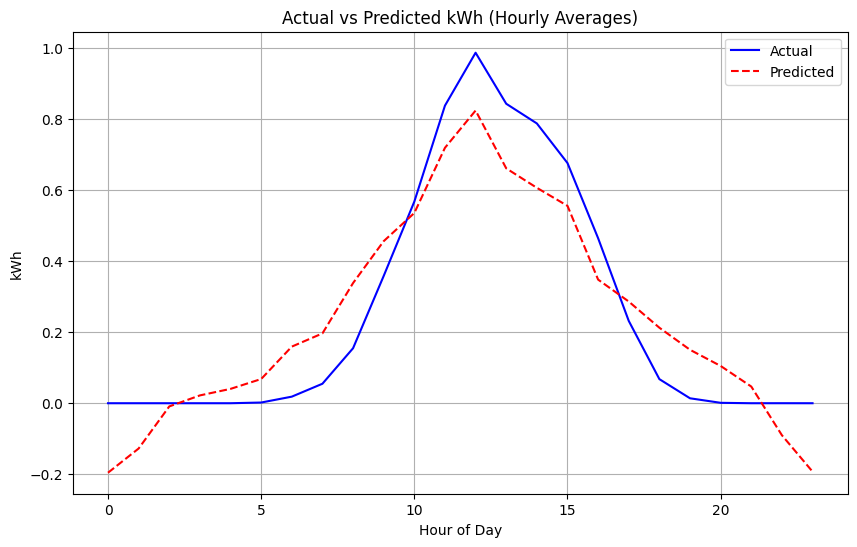

In [38]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)

lr = mae

# graphing the accuracy of the model
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Hour': X_test["hour"]})
results = results.groupby('Hour').mean()

# Plot the results
plt.figure(figsize=(10, 6))
sns.lineplot(data=results, x='Hour', y='Actual', label='Actual', color='blue')
sns.lineplot(data=results, x='Hour', y='Predicted', label='Predicted', color='red', linestyle='--')
plt.xlabel('Hour of Day')
plt.ylabel('kWh')
plt.title('Actual vs Predicted kWh (Hourly Averages)')
plt.legend()
plt.grid(True)
plt.show()

## Random Forest

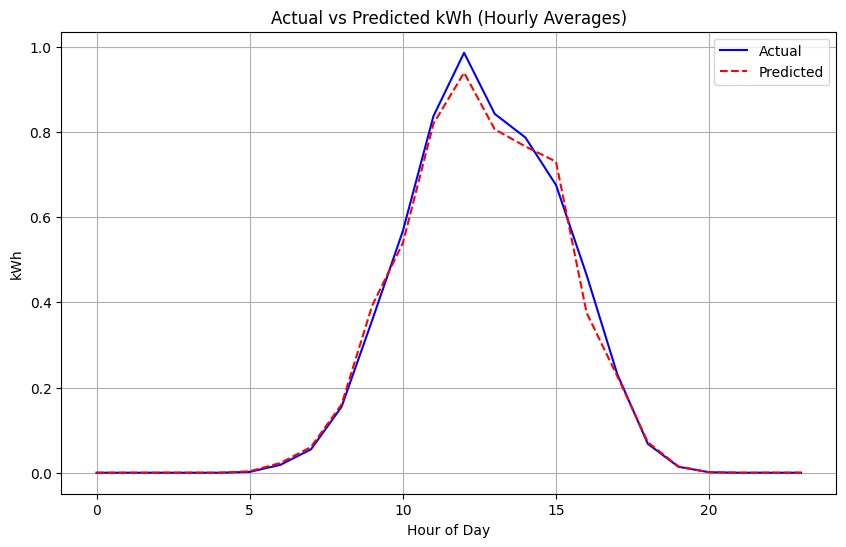

In [39]:
model = RandomForestRegressor()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)

rf = mae

# graphing the accuracy of the model
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Hour': X_test["hour"]})
results = results.groupby('Hour').mean()

# Plot the results
plt.figure(figsize=(10, 6))
sns.lineplot(data=results, x='Hour', y='Actual', label='Actual', color='blue')
sns.lineplot(data=results, x='Hour', y='Predicted', label='Predicted', color='red', linestyle='--')
plt.xlabel('Hour of Day')
plt.ylabel('kWh')
plt.title('Actual vs Predicted kWh (Hourly Averages)')
plt.legend()
plt.grid(True)
plt.show()

## Decision Tree

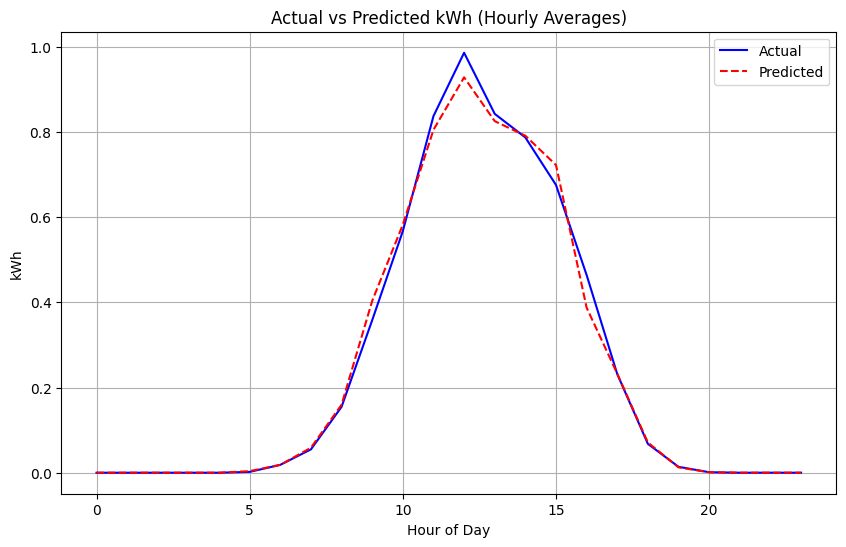

In [40]:
model = DecisionTreeRegressor()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)

dt = mae

# graphing the accuracy of the model
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Hour': X_test["hour"]})
results = results.groupby('Hour').mean()

# Plot the results
plt.figure(figsize=(10, 6))
sns.lineplot(data=results, x='Hour', y='Actual', label='Actual', color='blue')
sns.lineplot(data=results, x='Hour', y='Predicted', label='Predicted', color='red', linestyle='--')
plt.xlabel('Hour of Day')
plt.ylabel('kWh')
plt.title('Actual vs Predicted kWh (Hourly Averages)')
plt.legend()
plt.grid(True)
plt.show()

## SVR

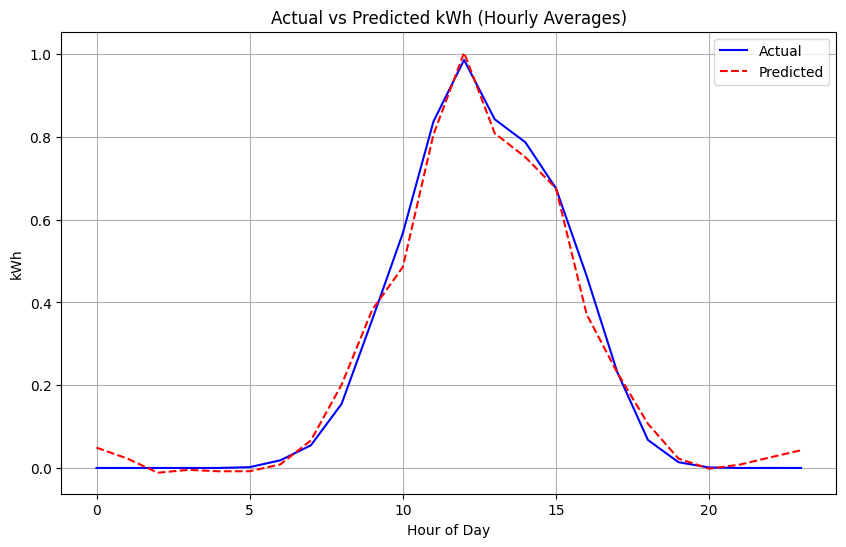

In [41]:
model = SVR()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)

svr = mae

# graphing the accuracy of the model
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Hour': X_test["hour"]})
results = results.groupby('Hour').mean()

# Plot the results
plt.figure(figsize=(10, 6))
sns.lineplot(data=results, x='Hour', y='Actual', label='Actual', color='blue')
sns.lineplot(data=results, x='Hour', y='Predicted', label='Predicted', color='red', linestyle='--')
plt.xlabel('Hour of Day')
plt.ylabel('kWh')
plt.title('Actual vs Predicted kWh (Hourly Averages)')
plt.legend()
plt.grid(True)
plt.show()

# Results

In [42]:
lr, rf, dt, svr
print(f"Linear Regression: {lr}\nRandom Forest: {rf}\nDecision Tree: {dt}\nSupport Vector Regression: {svr}")

Linear Regression: 0.2083132531780609
Random Forest: 0.06633731854610005
Decision Tree: 0.08133851063829903
Support Vector Regression: 0.09170291041123839


In [43]:
# saving the best model

pipeline = Pipeline([("prep", scaler), ("rf", RandomForestRegressor(random_state=42))])
param_grid = {
    "rf__n_estimators": [100, 200, 300],
    "rf__max_depth": [5, 10, 15]}

# grid search

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep', StandardScaler()),
                                       ('rf',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [5, 10, 15],
                         'rf__n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [44]:
grid_search.best_score_, grid_search.best_params_

(-0.018971750710793083, {'rf__max_depth': 15, 'rf__n_estimators': 300})

In [45]:
rf_model = grid_search.best_estimator_

In [46]:
rf_pred = rf_model.predict(X_test)

print(f"Random Forest: {mean_absolute_error(y_test, rf_pred)}")

Random Forest: 0.06574428794245593


In [47]:
dump(rf_model, "model.joblib")

['model.joblib']